# Reading and visualising data

In [1]:
import numpy as np
import tools21cm as t2c

import warnings
warnings.filterwarnings("ignore")

Different simulation codes write their output in different formats. The same applies to observations, which will vary based on the observation facility and research group. Therefore, it is necessary to define a function specific to each case.

To manipulate and analyze data with tools21cm, it is desirable to read the data as a numpy array.

### Reading data
Here we read the ionisation fraction data cube produced with the [C2Ray](https://github.com/garrelt/C2-Ray3Dm) code. For the density field, we will consider the gridded density field created by an N-body, [CubeP3M](https://github.com/jharno/cubep3m), which were used by [C2Ray](https://github.com/garrelt/C2-Ray3Dm) code as input.

We provide few simulation output for test: https://doi.org/10.5281/zenodo.3953639. To download this files to your current working directory feel free to run; read the README file for details. 


In [3]:
# !wget https://zenodo.org/record/3953639/files/7.059n_all.dat https://zenodo.org/record/3953639/files/7.059v_all.dat https://zenodo.org/record/3953639/files/README https://zenodo.org/record/3953639/files/xfrac3d_7.059.bin
# Move them to directory name data for convenience
!mkdir data/
!mv 7.059n_all.dat 7.059v_all.dat README xfrac3d_7.059.bin data/


--2023-06-11 18:14:43--  https://zenodo.org/record/3953639/files/7.059n_all.dat
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62500012 (60M) [application/octet-stream]
Saving to: ‘7.059n_all.dat’

7.059n_all.dat      100%[===================>]  59,60M  3,56MB/s    in 27s     

2023-06-11 18:15:14 (2,19 MB/s) - ‘7.059n_all.dat’ saved [62500012/62500012]

--2023-06-11 18:15:14--  https://zenodo.org/record/3953639/files/7.059v_all.dat
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 187500012 (179M) [application/octet-stream]
Saving to: ‘7.059v_all.dat’

7.059v_all.dat      100%[===================>] 178,81M  1,64MB/s    in 64s     

2023-06-11 18:16:19 (2,78 MB/s) - ‘7.059v_all.dat’ saved [187500012/187500012]

--2023-06-11 18:16:19--  https://zenodo.org/record/3953639/files/README
Reusing existing connec

In [2]:
path_to_datafiles = './data/'
z = 7.059  # redshift indicated in file

In [4]:
t2c.set_sim_constants(244) # This line is only useful while working with C2Ray simulations.

x_file = t2c.XfracFile(path_to_datafiles+'xfrac3d_7.059.bin')
d_file = t2c.DensityFile(path_to_datafiles+'7.059n_all.dat')

xfrac = x_file.xi
dens  = d_file.cgs_density

The above function `set_sim_constants` is useful only for `C2Ray` simulation outputs. This function takes as its only parameter the box side in cMpc/h and sets simulations constants.

See [here](https://tools21cm.readthedocs.io/contents.html#module-t2c.read_files) for more data reading functions.

### Visualising the data

You can of course plot the data you read using your favorite plotting software. For example, if you have `matplotlib` installed.

In [5]:
import matplotlib.pyplot as plt

In [6]:
box_dims = 244/0.7 # Length of the volume along each direction in Mpc.

dx, dy = box_dims/xfrac.shape[1], box_dims/xfrac.shape[2]
y, x = np.mgrid[slice(dy/2,box_dims,dy),
                slice(dx/2,box_dims,dx)]

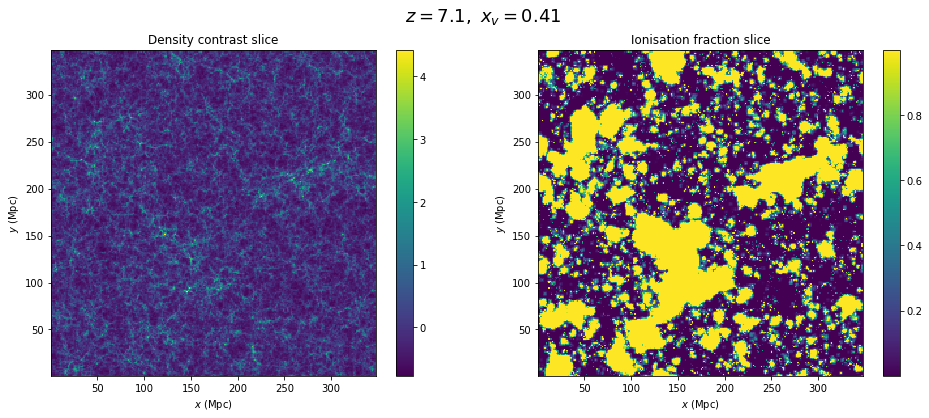

In [7]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.suptitle('$z={0:.1f},~x_v=${1:.2f}'.format(z,xfrac.mean()), size=18)

plt.subplot(121)
plt.title('Density contrast slice')
plt.pcolormesh(x, y, dens[0]/dens.mean()-1)
plt.xlabel('$x$ (Mpc)')
plt.ylabel('$y$ (Mpc)')
plt.colorbar()

plt.subplot(122)
plt.title('Ionisation fraction slice')
plt.pcolormesh(x, y, xfrac[0])
plt.xlabel('$x$ (Mpc)')
plt.ylabel('$y$ (Mpc)')
plt.colorbar()

plt.show()

# 21 cm brightness temperature

We can construct the 21 cm brightness temperature from the density field and ionisation fraction field using `calc_dt`. Due to the absence of zero baseline, the mean signal will be subtracted from each frequency channel. One can use `subtract_mean_signal` to add this effect.

In [8]:
dT = t2c.calc_dt(xfrac, dens, z)
print('Mean of first channel: {0:.4f}'.format(dT[0].mean()))

Mean of first channel: 11.8259


In [9]:
dT_subtracted = t2c.subtract_mean_signal(dT, 0)
print('Mean of first channel: {0:.4f}'.format(dT_subtracted[0].mean()))

Mean of first channel: -0.0000


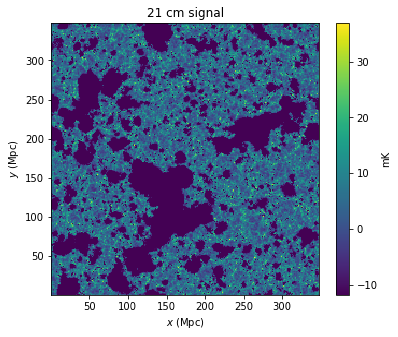

In [10]:
plt.rcParams['figure.figsize'] = [6, 5]

plt.title('21 cm signal')
plt.pcolormesh(x, y, dT_subtracted[0,:,:])
plt.xlabel('$x$ (Mpc)')
plt.ylabel('$y$ (Mpc)')
plt.colorbar(label='mK')

plt.show()

### 21 cm power spectrum

One of the most interesting metric to analyse this field is the power spectrum. Here we estimate the spherically average power spectrum using `power_spectrum_1d` function. 

The function needs the length of the `input_array` in Mpc (or Mpc/h) through `box_dims` parameters. This is used to calculate the wavenumbers (k). The unit of the output k values will be 1/Mpc (or h/Mpc). If the `input_array` has unequal length in each direction, then one can provide `box_dims` with a list containing the lengths in each direction.

In [11]:
box_dims = 244/0.7 # Length of the volume along each direction in Mpc.

In [12]:
ps, ks = t2c.power_spectrum_1d(dT_subtracted, kbins=15, box_dims=box_dims)

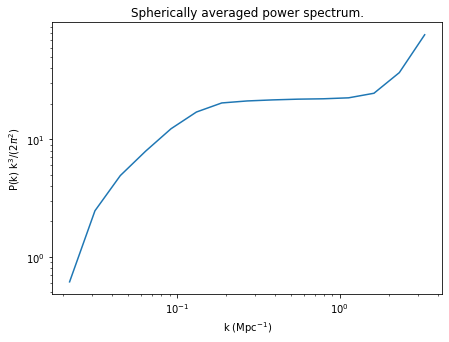

In [13]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.title('Spherically averaged power spectrum.')
plt.loglog(ks, ps*ks**3/2/np.pi**2)
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k$^{3}$/$(2\pi^2)$')

plt.show()

# Redshift-space distortions

The 21 cm signal will be modified while mapping from real space to redshift space due to peculiar velocities ([Mao et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.422..926M/abstract)).

The `VelocityFile` function is used to read the velocity files produced by `CubeP3M`. We need the velocities in km/s as a numpy array of shape `(3,nGridx,nGridy,nGridyz)`, where the first axis represent the velocity component along x, y and z spatial direction. The `get_kms_from_density` attribute gives such a numpy array.

In [14]:
v_file = t2c.VelocityFile(path_to_datafiles+'7.059v_all.dat')

In [15]:
kms = v_file.get_kms_from_density(d_file)

The `get_distorted_dt` function will distort the signal.

In [16]:
dT_rsd = t2c.get_distorted_dt(dT, kms, z, 
                              los_axis=0, 
                              velocity_axis=0, 
                              num_particles=20)

Spherically averaged power spectrum of the 21 cm signal with RSD.

In [17]:
ps_rsd, ks_rsd = t2c.power_spectrum_1d(dT_rsd, kbins=15, box_dims=box_dims)

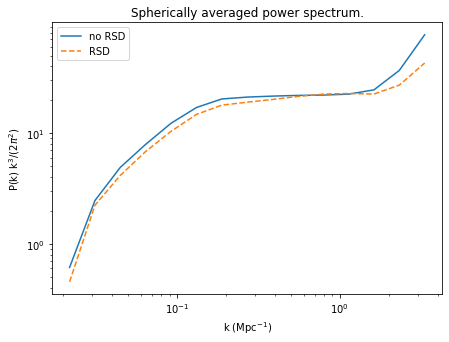

In [18]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.title('Spherically averaged power spectrum.')
plt.loglog(ks, ps*ks**3/2/np.pi**2, label='no RSD')
plt.loglog(ks_rsd, ps_rsd*ks_rsd**3/2/np.pi**2, linestyle='--', label='RSD')

plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k$^{3}$/$(2\pi^2)$')
plt.legend()

plt.show()

We see in the above figure that the spherically averaged power spectrum has changed after RSD is implemented.

However, a better marker of RSD in 21 cm signal is the power spectrum's $\mu (\equiv k_\parallel/k)$ dependence ([Jensen et al. 2013](https://academic.oup.com/mnras/article/435/1/460/1123792)). The power spectrum of 21 cm signal with RSD will have the following dependence ([Barkana & Loeb 2005](https://iopscience.iop.org/article/10.1086/430599)),

$P(k,\mu) = P_0 + \mu^2P_2 +\mu^4P_4$.

We can calculate $P(k,\mu)$ using `power_spectrum_mu` function.

In [19]:
Pk, mubins, kbins, nmode = t2c.power_spectrum_mu(
    dT,
    los_axis=0,
    mubins=8,
    kbins=15,
    box_dims=box_dims,
    exclude_zero_modes=True,
    return_n_modes=True,
    absolute_mus=False,
)

In [20]:
Pk_rsd, mubins_rsd, kbins_rsd, nmode_rsd = t2c.power_spectrum_mu(
    dT_rsd,
    los_axis=0,
    mubins=8,
    kbins=15,
    box_dims=box_dims,
    exclude_zero_modes=True,
    return_n_modes=True,
    absolute_mus=False,
)

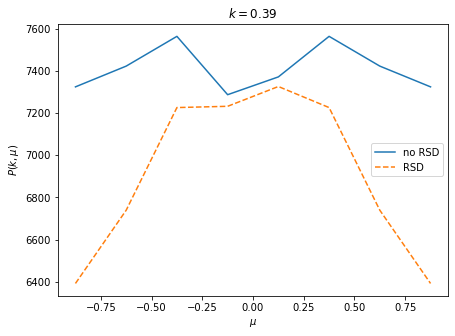

In [21]:
plt.rcParams['figure.figsize'] = [7, 5]
ii = 8

plt.title('$k={0:.2f}$'.format(kbins[ii]))
plt.plot(mubins, Pk[:,ii], label='no RSD')
plt.plot(mubins_rsd, Pk_rsd[:,ii], linestyle='--', label='RSD')

plt.xlabel('$\mu$')
plt.ylabel('$P(k,\mu)$')
plt.legend()

plt.show()

# Bubble size distribution

The bubble (HII regions) size distribution is an intersting probe of the reionization process ([Giri et al. 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.473.2949G/abstract)).

`Tools21cm` contains three methods to determine the size distributions, which are Friends-of-friends, Spherical average and mean free path approach.

In this tutorial, we will take the ionisation fraction field and assume all the pixels with value $>0.5$ as ionised.

In [22]:
xHII = xfrac>0.5

boxsize = 244/0.7 # in Mpc

Mean free path (e.g. [Mesinger & Furlanetto 2007](https://iopscience.iop.org/article/10.1086/521806/meta))

In [23]:
r_mfp, dn_mfp = t2c.mfp(xHII, boxsize=boxsize, iterations=1000000)

MFP method applied on 3D data (ver 1.0)
Initialising random rays...
...done
Estimating ray lengths...


 48%|███████████████████▋                     | 120/250 [00:06<00:07, 18.24it/s]


...done

Program runtime: 0.126151 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.


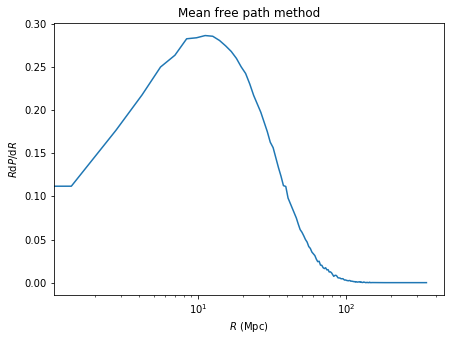

In [24]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.semilogx(r_mfp, dn_mfp)

plt.xlabel('$R$ (Mpc)')
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$')
plt.title('Mean free path method')

plt.show()

Spherical average (e.g. [Zahn et al. 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...654...12Z/abstract))

In [25]:
r_spa, dn_spa = t2c.spa(xHII, boxsize=boxsize, nscales=20)

100%|███████████████████████████████████████████| 20/20 [01:30<00:00,  4.51s/it]


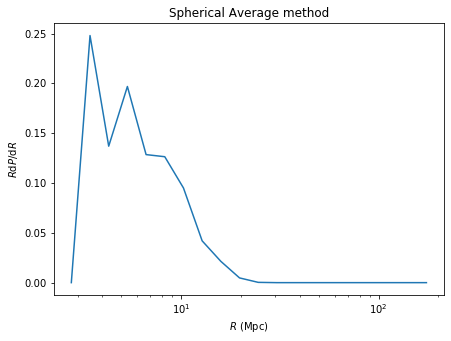

In [26]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.semilogx(r_spa, dn_spa)

plt.xlabel('$R$ (Mpc)')
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$')
plt.title('Spherical Average method')
plt.show()

Friends of friends (e.g. [Iliev et al. 2006](https://ui.adsabs.harvard.edu/abs/2006MNRAS.369.1625I/abstract))

In [27]:
labelled_map, volumes = t2c.fof(xHII)
fof_dist = t2c.plot_fof_sizes(volumes, bins=30, boxsize=boxsize)

Program runtime: 0.015371 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value


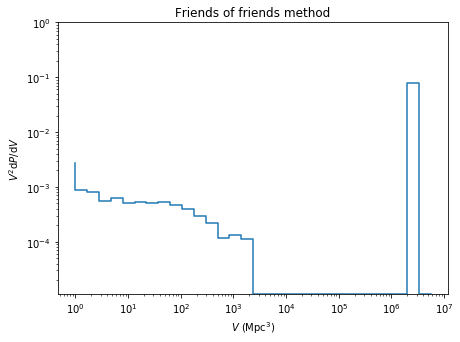

In [28]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.step(fof_dist[0], fof_dist[1])
plt.xscale('log')
plt.yscale('log')
plt.ylim(fof_dist[2],1)

plt.xlabel('$V$ (Mpc$^3$)')
plt.ylabel('$V^2\mathrm{d}P/\mathrm{d}V$')
plt.title('Friends of friends method')

plt.show()

# Telescope noise calculation. 
See [Ghara et al. 2016](https://arxiv.org/abs/1607.02779) and [Ghara et al. 2016](https://arxiv.org/abs/1801.06550) for more information

### uv-coverage
We start with calculation of the uv-coverage for SKA1-Low configuration.

In [29]:
uv, Nant = t2c.get_uv_daily_observation(ncells=dT.shape[0], # The number of cell used to make the image
                                        z=z,                # Redhsift of the slice observed
                                        filename=None,      # If None, it uses the SKA-Low 2016 configuration.
                                        total_int_time=6.0, # Observation per day in hours.
                                        int_time=10.0,      # Time period of recording the data in seconds.
                                        boxsize=boxsize,    # Comoving size of the sky observed
                                        declination=-30.0,
                                        verbose=True)

Making uv map from daily observations.


100%|███████████████████████████████████████| 2159/2159 [04:09<00:00,  8.65it/s]

...done


We suggest that you save the uv map as it is computationally expensive. Expecially when computed for an array of redshifts.

In [30]:
np.save(path_to_datafiles+'uv_map.npy', uv)
np.save(path_to_datafiles+'Nant.npy', Nant)

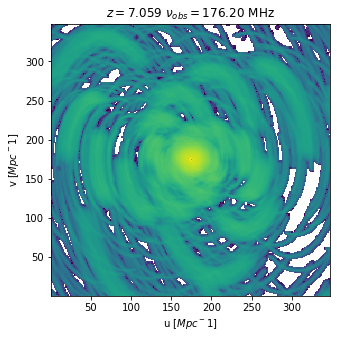

In [31]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.title(r'$z=%.3f$ $\nu_{obs}=%.2f$ MHz' %(z, t2c.z_to_nu(z)))
plt.pcolormesh(x, y, np.log10(np.fft.fftshift(uv)))
plt.xlabel('u [$Mpc^-1$]'), plt.ylabel('v [$Mpc^-1$]');

Here we plot the antennas location of the SKA1-Low configuration.

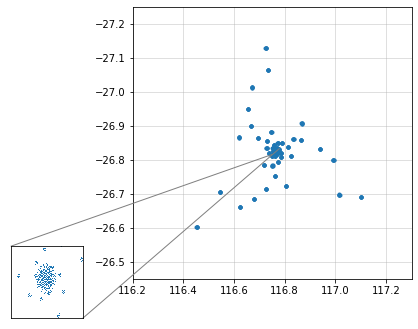

In [32]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

ska_ant = t2c.SKA1_LowConfig_Sept2016()

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(ska_ant[:,0], ska_ant[:,1], '.')
x1, x2, y1, y2 = 116.2, 117.3, -26.45, -27.25
ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)
ax.grid(b=True, alpha=0.5)

axins = inset_axes(ax, 1, 1, loc=4, bbox_to_anchor=(0.2, 0.2))
plt.plot(ska_ant[:,0], ska_ant[:,1], ',')
x1, x2, y1, y2 = 116.75, 116.78, -26.815, -26.833
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid(b=True, alpha=0.5)
mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.5")
axins.axes.xaxis.set_ticks([]);
axins.axes.yaxis.set_ticks([]);

### Creating the noise cube

In [33]:
noise_cube = t2c.noise_cube_coeval(ncells=dT.shape[0],
                                   z=z,
                                   depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                   obs_time=1000,
                                   filename=None,
                                   boxsize=boxsize,
                                   total_int_time=6.0,
                                   int_time=10.0,
                                   declination=-30.0,
                                   uv_map=uv,
                                   N_ant=Nant,
                                   verbose=True,
                                   fft_wrap=False)

Creating the noise cube...


100%|████████████████████████████████████████| 250/250 [00:02<00:00, 120.25it/s]


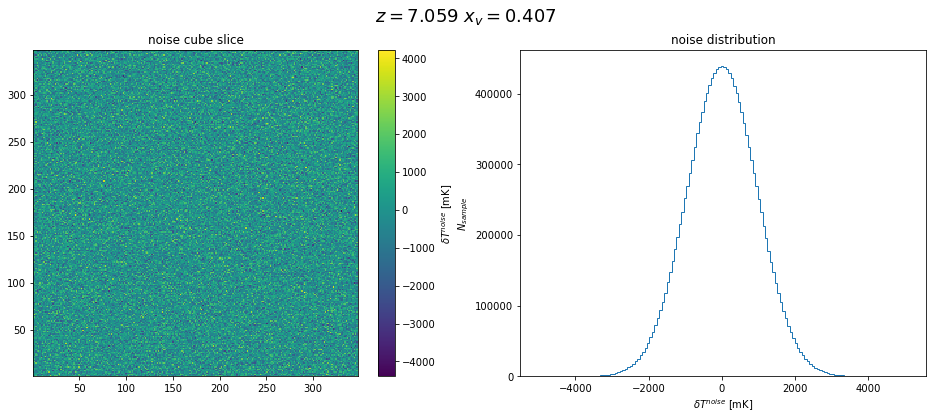

In [34]:
plt.rcParams['figure.figsize'] = [16, 6]

plt.suptitle('$z=%.3f$ $x_v=%.3f$' %(z, xfrac.mean()), size=18)
plt.subplot(121)
plt.title('noise cube slice')
plt.pcolormesh(x, y, noise_cube[0])
plt.colorbar(label='$\delta T^{noise}$ [mK]')
plt.subplot(122)
plt.title('noise distribution')
plt.hist(noise_cube.flatten(), bins=150, histtype='step');
plt.xlabel('$\delta T^{noise}$ [mK]'), plt.ylabel('$N_{sample}$');

### Create realistic 21-cm observational images
To create realistict observational images we combined the 21-cm filed with the noise cube and smooth the data to the resolution corresponding to maximum baseline of 2 km. The smoothing works for any kind of data (e.g. xHII, dT, etc.) and also for single dish. In the former case the max_baseline should be substituted to `D/122`, where D is the antenna disk diameter.

In [35]:
dT2 = dT_subtracted + noise_cube

dT_smooth = t2c.smooth_coeval(cube=dT2,    # Data cube that is to be smoothed
                              z=z,                  # Redshift of the coeval cube
                              box_size_mpc=boxsize, # Box size in cMpc
                              max_baseline=2.0,     # Maximum baseline of the telescope
                              ratio=1.0,            # Ratio of smoothing scale in frequency direction
                              nu_axis=2)            # frequency axis

100%|████████████████████████████████████████| 250/250 [00:00<00:00, 268.96it/s]


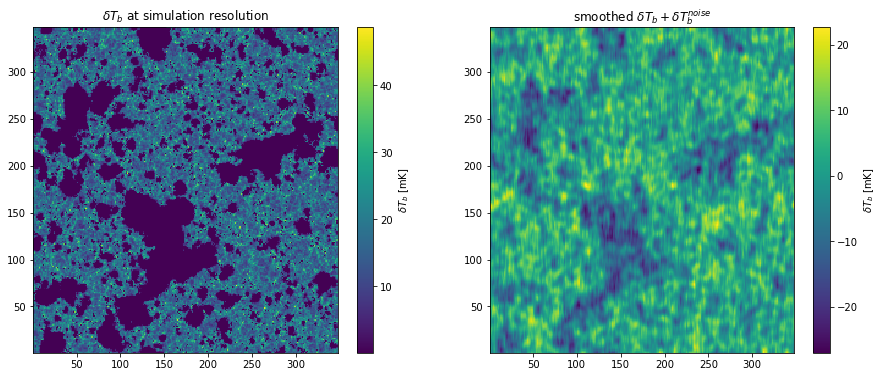

In [36]:
plt.rcParams['figure.figsize'] = [15, 6]

plt.subplot(121)
plt.title('$\delta T_b$ at simulation resolution')
plt.pcolormesh(x, y, dT[0])
plt.colorbar(label='$\delta T_b$ [mK]')
plt.subplot(122)
plt.title('smoothed $\delta T_b + \delta T^{noise}_b$')
plt.pcolormesh(x, y, dT_smooth[0])
plt.colorbar(label='$\delta T_b$ [mK]')

# Image segmenation with Tools21cm
The Identification of HII regions in noisy 21-cm interferometric images is not trivial. `Tools21cm` contains two methods to identify (segmentation) ionised/neutral regions: the `super-pixel` method [Giri et al. 2018](https://arxiv.org/abs/1801.06550) and the deep learning algorithm `SegU-Net` [Bianco et al. 2022](https://academic.oup.com/mnras/article/505/3/3982/6286907?login=false).

In this tutorial, we will take the ionisation fraction field and assume all the pixels with value $>0.5$
as ionised.

### The superpixel algorithm
We start by calculating the superpixel labels

In [37]:
%%time
labels = t2c.slic_cube(cube=dT_smooth,
                       n_segments=5000,
                       compactness=0.1,
                       max_iter=20,
                       sigma=0,
                       min_size_factor=0.5,
                       max_size_factor=3,
                       cmap=None)

Estimating superpixel labels using SLIC...
The output contains the labels with 4911 segments
CPU times: user 3min 42s, sys: 375 ms, total: 3min 42s
Wall time: 3min 43s


Make the superpixel cube and plot a slice.

Estimating the superpixel mean map...


100%|████████████████████████████████████| 4911/4911 [00:00<00:00, 51612.08it/s]


...done
Constructing the superpixel map...


100%|███████████████████████████████████████| 4911/4911 [01:16<00:00, 64.19it/s]


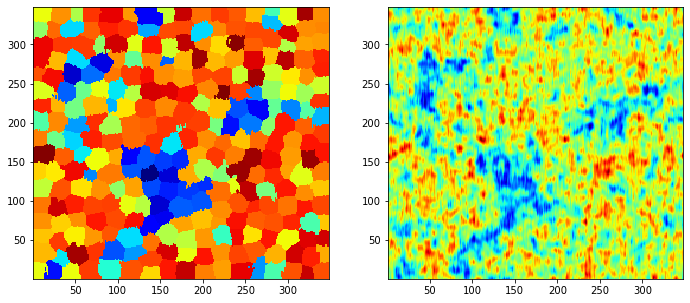

In [38]:
superpixel_map = t2c.superpixel_map(dT_smooth, labels)

plt.rcParams['figure.figsize'] = [18, 5]
plt.subplot(131)
plt.pcolormesh(x, y, superpixel_map[0], cmap='jet')
plt.subplot(132)
plt.pcolormesh(x, y, dT_smooth[0], cmap='jet')

Stitch the superpixels using the superpixel PDFs and plot a slice from identified ionized region cube. Then smooth the true ionisation fraction field to compare.

In [39]:
xHII_stitch = t2c.stitch_superpixels(data=dT_smooth,
                                     labels=labels,
                                     bins='knuth',
                                     binary=True,
                                     on_superpixel_map=True)

mask_xHI = t2c.smooth_coeval(xfrac, z, box_size_mpc=boxsize, max_baseline=2.0, nu_axis=2) < 0.5

Estimating the superpixel mean map...


100%|████████████████████████████████████| 4911/4911 [00:00<00:00, 57067.18it/s]


...done
Constructing the superpixel map...


100%|████████████████████████████████████████| 250/250 [00:01<00:00, 194.97it/s]


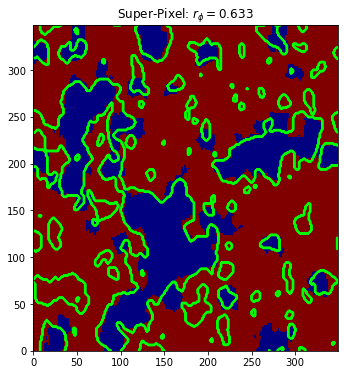

In [40]:
from sklearn.metrics import matthews_corrcoef

phicoef_sup = matthews_corrcoef(mask_xHI.flatten(), 1-xHII_stitch.flatten())

plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(121)
plt.title('Super-Pixel: $r_{\phi}=%.3f$' %phicoef_sup)
plt.pcolormesh(x, y, 1-xHII_stitch[0], cmap='jet')
plt.contour(mask_xHI[0], colors='lime', extent=[0, boxsize, 0, boxsize])

### SegU-Net
Here, we load the best performing network and calculate the nubmer of manipulation on the cube to evaluate the pixel-uncertainty. Additionally, we can get pixel-error maps 
 
<ul>
  <li>tta = 0 : super-fast (approximatelly 7 sec), it tends to be a few percent less accurate (within 2% differences), no pixel-error map (no TTA manipulation)</li>
  <li>tta = 1 : fast (about 17 sec), accurate, with pixel-error map (3 samples)</li>
  <li>tta = 2 : slow (about 10 min), accurate, with pixel-error map (~100 samples)</li>
</ul>  


In [42]:
seg = t2c.segmentation.segunet21cm(tta=2, verbose=True)

tot number of (unique) manipulation we can do on a cube: 28
 Loaded model: /home/michele/codes/tools21cm/src/tools21cm/input_data/segunet_03-11T12-02-05_128slice_ep35.h5


In the current version of `Tools21cm`, the network operates on data cubes with a mesh size of $128^3$. In future updates, we plan to extend to cover the mesh size of any given input. Moreover, `SegU-Net` is optimised for cube data with and spatial resolution of $2\,Mpc$. However, it deals well with simulation with smaller resolution.

For the reason mentioned above, here we cut the differential brightness cube and `Super-Pixel` output in order to match `SegU-Net` input shape.

In [43]:
dT_cut = dT_smooth[:128,:128,:128]
mask_xHI2 = mask_xHI[:128,:128,:128]

xHI_seg, xHI_seg_err = seg.prediction(x=dT_cut)
phicoef_seg = matthews_corrcoef(mask_xHI2.flatten(), xHI_seg.flatten())

xHI_sup = xHII_stitch[:128,:128,:128]
phicoef_sup = matthews_corrcoef(mask_xHI2.flatten(), 1-xHI_sup.flatten())

100%|███████████████████████████████████████████| 28/28 [19:38<00:00, 42.09s/it]


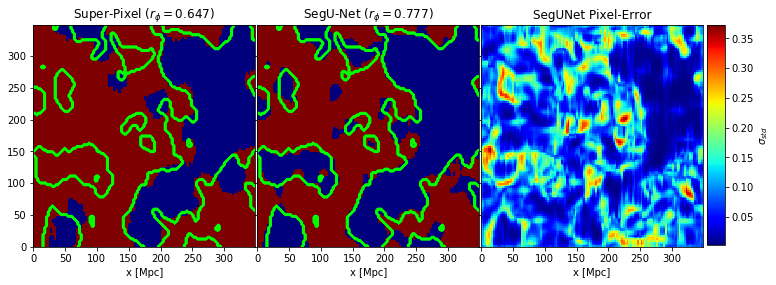

In [46]:
fig, axs = plt.subplots(figsize=(12,6), ncols=3, sharey=True, sharex=True)
(ax0, ax1, ax2) = axs

ax0.set_title('Super-Pixel ($r_{\phi}=%.3f$)' %phicoef_sup)
ax0.imshow(1-xHI_sup[0], origin='lower', cmap='jet', extent=[0, boxsize, 0, boxsize])
ax0.contour(mask_xHI2[0], colors='lime', extent=[0, boxsize, 0, boxsize])
ax0.set_xlabel('x [Mpc]')

ax1.set_title('SegU-Net ($r_{\phi}=%.3f$)' %phicoef_seg)
ax1.imshow(xHI_seg[0], origin='lower', cmap='jet', extent=[0, boxsize, 0, boxsize])
ax1.contour(mask_xHI2[0], colors='lime', extent=[0, boxsize, 0, boxsize])
ax1.set_xlabel('x [Mpc]')

ax2.set_title('SegUNet Pixel-Error')
im = ax2.imshow(xHI_seg_err[0], origin='lower', cmap='jet', extent=[0, boxsize, 0, boxsize])
fig.colorbar(im, label=r'$\sigma_{std}$', ax=ax2, pad=0.02, cax=fig.add_axes([0.905, 0.25, 0.02, 0.51]))
ax2.set_xlabel('x [Mpc]')

plt.subplots_adjust(hspace=0.1, wspace=0.01)
for ax in axs.flat: ax.label_outer()